In [1]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/MyDrive/DL_Project_Group3"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import os.path as osp
import os

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from tensorflow.keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.python import tf2

In [3]:
SEED = 13

#Function to initialize seeds for all libraries which might have stochastic behavior
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Activate Tensorflow deterministic behavior
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
path_labels_df = pd.read_csv(PATH + "/data/path_labels_cat.csv")
path_labels_df_sample = path_labels_df.sample(10000, random_state=13)
train, test = train_test_split(path_labels_df_sample, test_size=0.2, random_state=13, stratify=path_labels_df_sample[['Smiling']])

https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060

# VGG19

In [23]:
height, width, channels = 218, 178, 3 
class_mode = 'binary'
batch_size = 64
color_mode = 'rgb'

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

# Note that the validation data should not be augmented beyond rescaling!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_dataframe(train, # training dataframe
                                                    directory = PATH + "/", # absolute path for G. Drive reop
                                                    x_col = "path",
                                                    y_col = "Smiling",
                                                    target_size = (height, width),
                                                    color_mode = color_mode,
                                                    class_mode = class_mode,
                                                    shuffle = True, 
                                                    batch_size = batch_size,
                                                    seed = 13)

test_generator = test_datagen.flow_from_dataframe(test,
                                                    directory = PATH + "/",
                                                    x_col = "path",
                                                    y_col = "Smiling",
                                                    target_size = (height, width),
                                                    color_mode = color_mode,
                                                    class_mode = class_mode, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    seed = 13)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [6]:
set_global_determinism(seed=SEED)

vgg19_model = vgg19.VGG19(include_top=False, input_shape=(218, 178, 3))

for layer in vgg19_model.layers[:-8]:
  layer.trainable=False

conv_new = Conv2D(512, (3,3), activation='tanh', padding='same', name='block6_conv1',
                  kernel_initializer=GlorotUniform(seed=13))(vgg19_model.layers[-1].output)
conv_new_2 = Conv2D(512, (3,3), activation='tanh', padding='same', name='block6_conv2',
                    kernel_initializer=GlorotUniform(seed=13))(conv_new)
pool_new = MaxPooling2D((2,2), strides=(2,2), name='block6_pool')(conv_new_2) 
flat1 = Flatten()(pool_new)
class1 = Dense(512, activation='relu',
               kernel_initializer=GlorotUniform(seed=13))(flat1)
output = Dense(1, activation='sigmoid',
               kernel_initializer=GlorotUniform(seed=13))(class1)

vgg19_model_combined = Model(inputs = vgg19_model.inputs, outputs = output)

adam = tf.keras.optimizers.Adam(
                                learning_rate=0.01,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-01,
                                amsgrad=False
)

vgg19_model_combined.compile(loss = 'binary_crossentropy', optimizer=adam, metrics=['accuracy'])

my_callbacks = [
    ModelCheckpoint(filepath=osp.join(PATH,'models/vgg19_jason_v2.h5'),
                    save_best_only=True)
]
history_vgg19 = vgg19_model_combined.fit(train_generator,
                    validation_data = test_generator,
                    epochs=20, 
                    verbose=1,
                    steps_per_epoch=len(train)//batch_size,
                    callbacks=my_callbacks)

Epoch 1/20
125/125 [==============================] - 142s 1s/step - loss: 0.5396 - accuracy: 0.7151 - val_loss: 0.3080 - val_accuracy: 0.8690
Epoch 2/20
125/125 [==============================] - 140s 1s/step - loss: 0.3226 - accuracy: 0.8650 - val_loss: 0.2598 - val_accuracy: 0.9035
Epoch 3/20
125/125 [==============================] - 136s 1s/step - loss: 0.3015 - accuracy: 0.8744 - val_loss: 0.2967 - val_accuracy: 0.8745
Epoch 4/20
125/125 [==============================] - 135s 1s/step - loss: 0.2568 - accuracy: 0.8920 - val_loss: 0.2916 - val_accuracy: 0.8750
Epoch 5/20
125/125 [==============================] - 138s 1s/step - loss: 0.2509 - accuracy: 0.8961 - val_loss: 0.2487 - val_accuracy: 0.8975
Epoch 6/20
125/125 [==============================] - 135s 1s/step - loss: 0.2366 - accuracy: 0.9001 - val_loss: 0.2741 - val_accuracy: 0.8850
Epoch 7/20
125/125 [==============================] - 138s 1s/step - loss: 0.2325 - accuracy: 0.9064 - val_loss: 0.2120 - val_accuracy: 0.9075

Text(0.5, 1.0, 'Loss Curves')

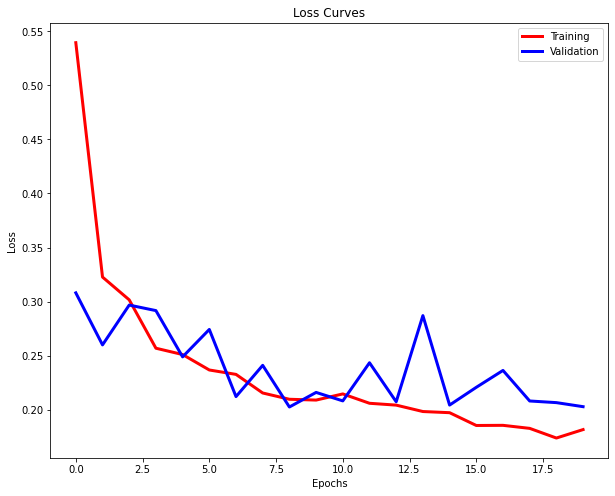

In [7]:
plt.figure(figsize=[10,8])
plt.plot(history_vgg19.history['loss'],'r',linewidth=3.0)
plt.plot(history_vgg19.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

In [9]:
#VGG19 with one fewer trainable layers and one more conv2d layer
score = vgg19_model_combined.evaluate(test_generator, verbose=0)
print('Test loss:', score)

Test loss: [0.2026391327381134, 0.9129999876022339]


In [24]:
predictions = vgg19_model_combined.predict(test_generator)

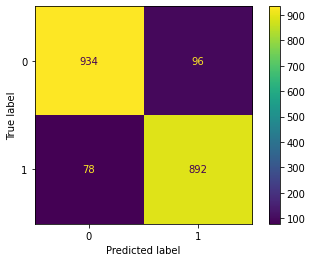

In [28]:
# Get most likely class
predicted_classes = np.round(predictions)
true_classes = test_generator.labels

# confusion matrix
cm = confusion_matrix(true_classes,predicted_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

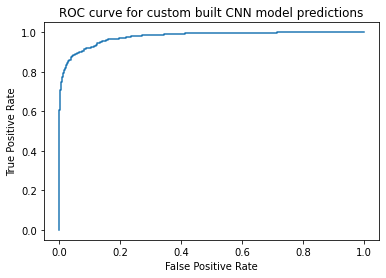

In [29]:
# roc curve
y_prob = predictions[:,0]
fpr, tpr, thresholds = roc_curve(true_classes, y_prob, pos_label=1)
plt.plot(fpr,tpr)
plt.title('ROC curve for custom built CNN model predictions')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

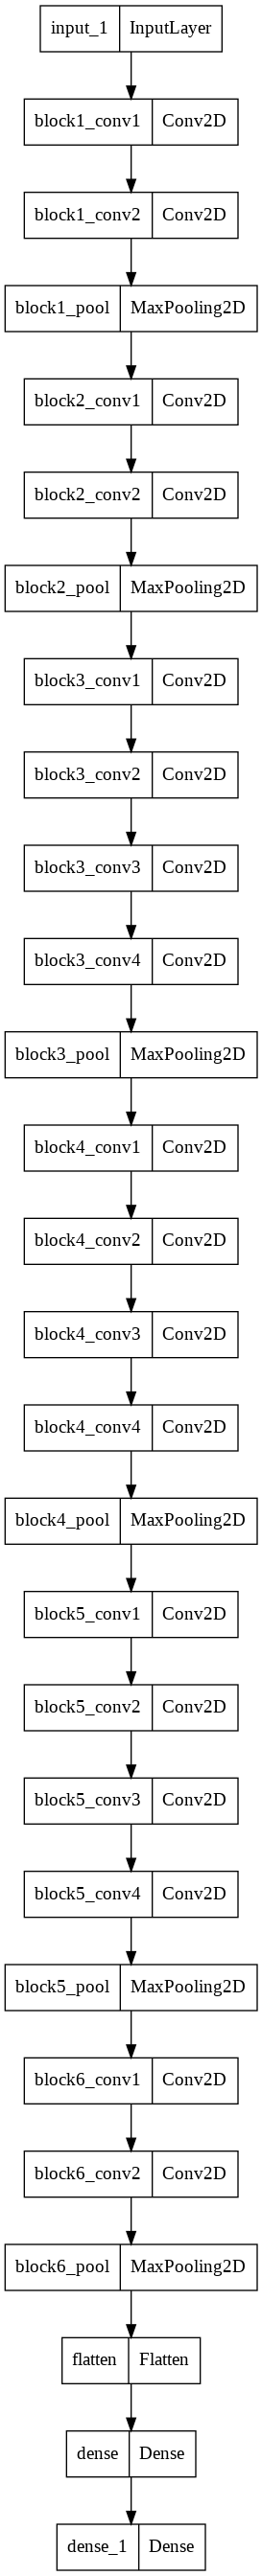

In [30]:
plot_model(vgg19_model_combined)

# Exploratory Data Analysis

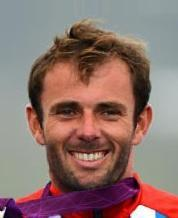

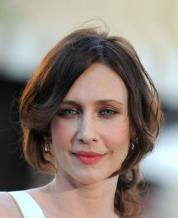

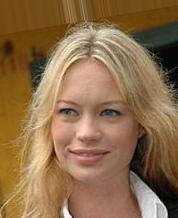

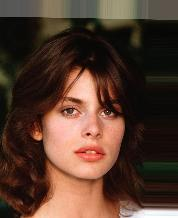

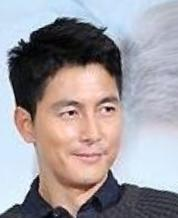

In [32]:
import cv2
from google.colab.patches import cv2_imshow
import random
img_num = 100000 + random.randint(0,1000)
for i in range(img_num, img_num+5):
  img = cv2.imread("/content/drive/MyDrive/DL_Project_Group3/data/raw/batch_100/" + str(i) + ".jpg")
  cv2_imshow(img)

In [33]:
path_labels_df = pd.read_csv(PATH + "/data/path_labels_cat.csv")
path_labels_df_sample = path_labels_df.sample(100, random_state=13)

In [34]:
height, width, channels = 218, 178, 3 
class_mode = 'binary'
batch_size = 32
color_mode = 'rgb'

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator()


sample_generator = train_datagen.flow_from_dataframe(path_labels_df_sample, # training dataframe
                                                    directory = PATH + "/", # absolute path for G. Drive reop
                                                    x_col = "path",
                                                    y_col = "Smiling",
                                                    target_size = (height, width),
                                                    color_mode = color_mode,
                                                    class_mode = class_mode,
                                                    shuffle = True, 
                                                    batch_size = batch_size)


Found 100 validated image filenames belonging to 2 classes.


In [35]:
plt.rcParams.update({'font.size': 12})

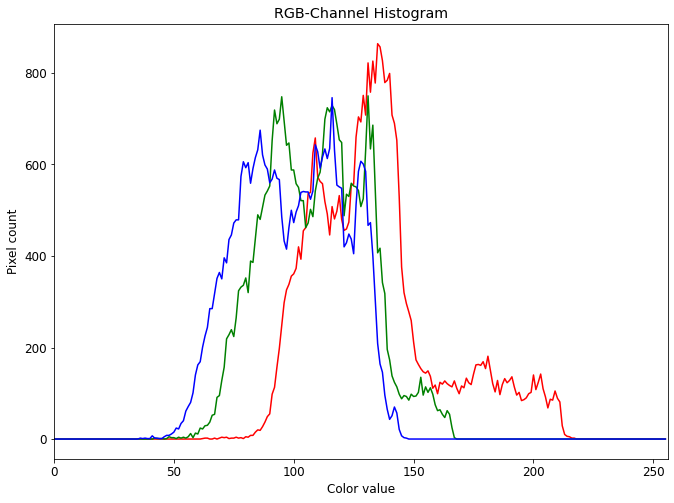

In [36]:
batch_0 = next(iter(sample_generator))
res = np.zeros(shape=(218,178,3))
for image in batch_0[0]: #batch_0[0] gives the x-values, while batch_0[1] gives labels
  res += image
res /= len(batch_0[0])

# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure(figsize=(11,8))
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        res[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("RGB-Channel Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()